In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
from tqdm import tqdm
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

In [2]:
## Load reject data.
reject = read_csv(os.path.join('data','reject.csv'))

## Initialize metrics DataFrame.
metrics = reject[['platform','subject','infreq']]

## Section 1: Define Behavioral Metrics

In [3]:
## Load behavioral data.
data = read_csv(os.path.join('data','data.csv'))

## Restrict participants.
data = data.loc[data.subject.isin(reject.subject)]

#### 1.1 Accuracy

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Merge with metrics.
metrics = metrics.merge(reject[['platform','subject','accuracy']])

#### 1.2 Points

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute performance within participants.
gb = data.groupby(['platform','subject']).outcome.sum().reset_index()
gb = gb.rename(columns={'outcome':'points'})

## Merge with metrics.
metrics = metrics.merge(gb)

#### 1.3 Win Stay Rates

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute previous win.
f = lambda x: np.roll(x, 1)
data['prev_win'] = data.groupby(['platform','subject']).outcome.transform(f)
data.loc[data.trial==1, 'prev_win'] = np.nan

## Compute stay.
f = lambda x: (x == np.roll(x,1)).astype(int)
data['stay'] = data.groupby(['platform','subject']).choice.transform(f)
data.loc[data.trial==1, 'stay'] = np.nan

## Compute win-stay rate.
gb = data.query('prev_win==1').groupby(['platform','subject']).stay.mean().reset_index()
gb = gb.rename(columns={'stay':'ws'})

## Merge with metrics.
metrics = metrics.merge(gb)

#### 1.4 Lose Shift Rates

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute win-stay rate.
gb = data.query('prev_win==0').groupby(['platform','subject']).stay.mean().reset_index()
gb = gb.rename(columns={'stay':'ls'})
gb['ls'] = 1 - gb['ls']

## Merge with metrics.
metrics = metrics.merge(gb)

#### 1.5 Perseveration

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define trial number within each block.
data['exposure'] = data.groupby(['subject','block']).trial.transform(lambda x: np.arange(x.size)+1)

## Define perseveration errors.
data['perseveration'] = data.groupby('subject').correct.transform(lambda x: np.roll(x, 15))
data['perseveration'] = (data['perseveration'] == data['choice']).astype(int)
data.loc[data.block==1,'perseveration'] = np.nan

## Compute perseveration errors within participants.
gb = data.groupby(['platform','subject']).perseveration.mean().reset_index()

## Merge with metrics.
metrics = metrics.merge(gb)

## Section 2: Define Self-Report Metrics

In [9]:
## Load survey data.
surveys = read_csv(os.path.join('data','surveys.csv'))

## Restrict participants.
surveys = surveys.loc[surveys.subject.isin(metrics.subject)]

#### 2.1 Self-Report Sum Scores

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define subscales.
subscales = {
    '7u':    ['7u7d-q01','7u7d-q03','7u7d-q04','7u7d-q06','7u7d-q07','7u7d-q08','7u7d-q13'],
    '7d':    ['7u7d-q02','7u7d-q05','7u7d-q09','7u7d-q10','7u7d-q11','7u7d-q12','7u7d-q14'],
    'gad7':  ['gad7-q01','gad7-q02','gad7-q03','gad7-q04','gad7-q05','gad7-q06','gad7-q07'],
    'bb1':   ['bisbas-q01','bisbas-q02','bisbas-q03','bisbas-q04'],
    'bb2':   ['bisbas-q05','bisbas-q06','bisbas-q07','bisbas-q08'],
    'bb3':   ['bisbas-q09','bisbas-q10','bisbas-q11','bisbas-q12'],
    'shaps': ['shaps-q01','shaps-q02','shaps-q03','shaps-q04','shaps-q05',
              'shaps-q06','shaps-q07','shaps-q08','shaps-q09','shaps-q10',
              'shaps-q11','shaps-q12','shaps-q13','shaps-q14'],
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Iteratively compute sum scores.
for k, v in subscales.items():
    
    surveys[k] = surveys[v].sum(axis=1)
    
## Merge with metrics.
metrics = metrics.merge(surveys[['subject','platform'] + list(subscales.keys())])

## Section 3: Primary Analysis

#### 3.1 Percentile Bootstrap Analysis

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define queries.
queries = [
    'infreq > -1',
    'accuracy > 0.411',
    'infreq == 0',
    'accuracy > 0.411 and infreq == 0'
]

## Define variables of interest.
rows = ['accuracy','points','ws','ls','perseveration']
cols = ['7u','7d','gad7','bb1','bb2','bb3','shaps']

## Define number of bootstraps.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Percentile bootstrap. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
corr = np.zeros(( len(queries), len(rows), len(cols) ))
pval = np.zeros_like(corr)

## Main loop.
for i, query in enumerate(queries):
    
    ## Copy DataFrame.
    df = metrics.query(query).copy()
    indices = np.arange(df.shape[0])
    
    ## Compute observed correlations.
    corr[i] = df.corr(method='spearman').loc[rows,cols].values
    
    ## Preallocate space.
    null = np.zeros((n_iter, len(rows), len(cols)))
    
    ## Iteratively compute null distribution.
    for j in tqdm(range(n_iter)):
        
        ## Sample bootstrap sequence.
        ix = np.random.choice(indices, indices.size, replace=True)

        ## Compute bootstrap correlations.
        null[j] = df.iloc[ix].corr(method='spearman').loc[rows,cols].values
        
    ## Compute p-values.
    pval[i] = np.where(np.sign(corr[i]) > 0, null < 0, null > 0).mean(axis=0)

100%|██████████| 5000/5000 [01:03<00:00, 79.25it/s]


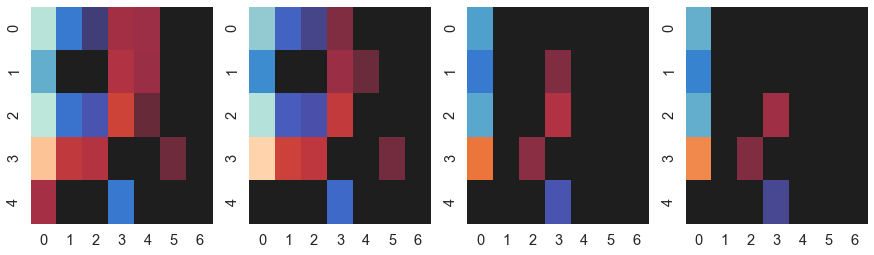

In [12]:
fig, axes = plt.subplots(1,4,figsize=(15,4))

for i, ax in enumerate(axes):
    
    sns.heatmap( np.where(pval[i] < 0.05, corr[i], 0), vmin=-0.3, vmax=0.3, center=0, cbar=False, ax=ax)